In [81]:
import pandas as pd

# Load the data from the uploaded CSV file
data_path = 'out.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset and its structure
#data.head(), data.info()


In [82]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

data['mood_shifted'] = data['mood'].shift(1)
#features = data.drop(['mood', 'id', 'screen', 'Unnamed: 0', '3_day_avg_mood','7_day_avg_activity','productivity_to_social_ratio','mood_quantiles', 'date'], axis=1)
features = data.drop(['mood', 'id', 'screen', 'Unnamed: 0', 'mood_quantiles', 'date'], axis=1)

target = data['mood']
print(features.head(), features.info())


# Normalize the features
scaler = StandardScaler()
#features_scaled = scaler.fit_transform(features)
features_scaled = scaler.fit_transform(features.fillna(features.mean())) # Function to create sequences


# Convert to numpy arrays
features_np = np.array(features_scaled)
target_np = np.array(target)

# Create sequences for LSTM
def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:(i + window_size)])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

# Assuming we use a window size of 10 days
window_size = 10
X, y = create_sequences(features_np, target_np, window_size)

X.shape, y.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   activity                      1268 non-null   float64
 1   circumplex.arousal            1268 non-null   float64
 2   circumplex.valence            1268 non-null   float64
 3   appCat.builtin                1268 non-null   float64
 4   appCat.communication          1268 non-null   float64
 5   appCat.entertainment          1268 non-null   float64
 6   appCat.finance                1268 non-null   float64
 7   appCat.game                   1268 non-null   float64
 8   appCat.office                 1268 non-null   float64
 9   appCat.other                  1268 non-null   float64
 10  appCat.social                 1268 non-null   float64
 11  appCat.travel                 1268 non-null   float64
 12  appCat.unknown                1268 non-null   float64
 13  app

((1258, 10, 21), (1258,))

In [83]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, input):
        # Get the current batch size from input
        current_batch_size = input.size(0)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, current_batch_size, self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, current_batch_size, self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        lstm_out, (hn, cn) = self.lstm(input, (h0.detach(), c0.detach()))

        # Only take the output from the final timestep
        out = self.linear(lstm_out[:, -1, :])
        return out



# Parameters for the model
input_dim = 21
hidden_dim = 50
batch_size = 64
num_layers = 1
output_dim = 1

# Create the LSTM model instance
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
print(model)


LSTMModel(
  (lstm): LSTM(21, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [84]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Create a TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])



# Create DataLoaders for training and validation sets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


# # Assuming X_tensor and y_tensor are your features and targets respectively
# dataset = TensorDataset(X_tensor, y_tensor)

# # Calculate the sizes for training and validation sets
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size

# # Sequentially split the dataset into training and validation sets
# train_dataset = TensorDataset(X_tensor[:train_size], y_tensor[:train_size])
# val_dataset = TensorDataset(X_tensor[train_size:], y_tensor[train_size:])

# # Create DataLoaders for training and validation sets
# # Set shuffle=False for both if you want to preserve sequence order especially important for time series
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
# val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


# Function to calculate the loss over a whole dataset (for validation)
def evaluate(model, val_loader):
    model.eval()
    with torch.no_grad():
        losses = []
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            losses.append(loss.item())
        return sum(losses) / len(losses)

# Initialize the model
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    train_loss = evaluate(model, train_loader)
    val_loss = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')






Epoch 1, Training Loss: 44.86220049858093, Validation Loss: 50.47026348114014
Epoch 2, Training Loss: 40.50066375732422, Validation Loss: 48.35356044769287
Epoch 3, Training Loss: 27.0880868434906, Validation Loss: 40.75900220870972
Epoch 4, Training Loss: 6.664274841547012, Validation Loss: 20.610074162483215
Epoch 5, Training Loss: 1.1919473558664322, Validation Loss: 12.615163683891296
Epoch 6, Training Loss: 0.5513438014313579, Validation Loss: 11.108938232064247
Epoch 7, Training Loss: 0.531978533603251, Validation Loss: 10.850173652172089
Epoch 8, Training Loss: 0.5309923077002168, Validation Loss: 10.824520505964756
Epoch 9, Training Loss: 0.526007067412138, Validation Loss: 10.8418038636446
Epoch 10, Training Loss: 0.5235735261812806, Validation Loss: 10.855087794363499
Epoch 11, Training Loss: 0.5216324143111706, Validation Loss: 10.857019908726215
Epoch 12, Training Loss: 0.5194314206019044, Validation Loss: 10.85362096130848
Epoch 13, Training Loss: 0.5170164527371526, Valid

In [85]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(val_loader)


In [86]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit


n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have prepared your entire dataset:
# X_all and y_all are your features and labels, respectively, in a numpy array format
X_tensor = torch.tensor(X, dtype=torch.float32)
X_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, X_tensor)

fold=0
for train_index, val_index in tscv.split(X_tensor):


    train_dataset = Subset(dataset, train_index)
    val_dataset = Subset(dataset, val_index)

    # Create DataLoaders for training and validation sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)  # Usually no need to shuffle time series
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    # Now, you would use train_loader and val_loader within your training loop
    # This example will simply print out the sizes of each set for demonstration
    print(f"Training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples.")

    # Initialize and train your LSTM model
    model = LSTMModel(input_dim, hidden_dim, output_dim=1, num_layers=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    # Example training function (you might need to define it depending on your LSTM setup)
    train_model(model, train_loader, criterion, optimizer)

    # Evaluate the model on the validation set
    validation_loss = evaluate(model, val_loader)
    print(f"Validation loss for fold {fold}: {validation_loss}")
    fold += 1






Training on 213 samples, validating on 209 samples.


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

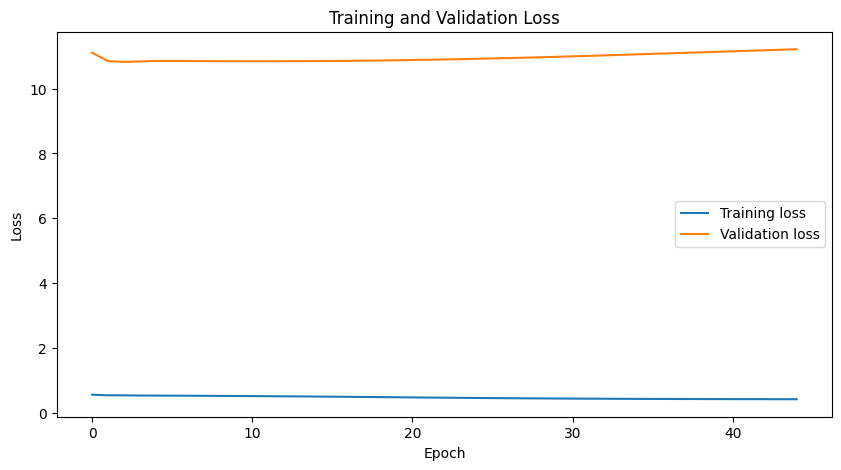

In [87]:

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses[5:], label='Training loss')
plt.plot(val_losses[5:], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

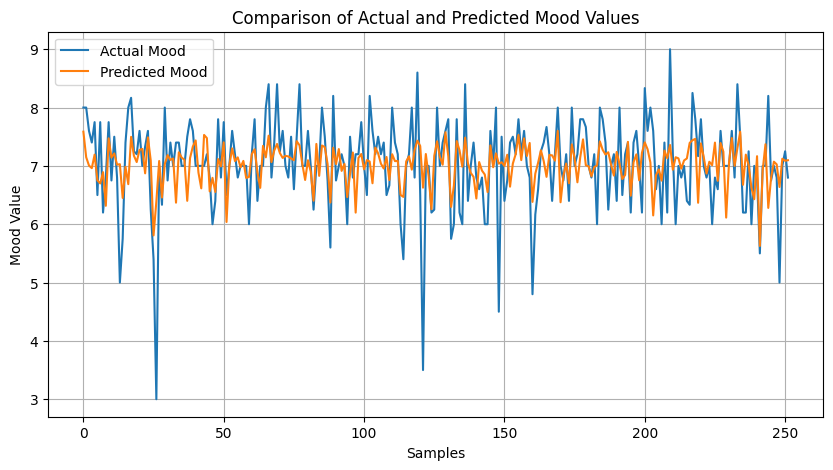

In [ ]:
import matplotlib.pyplot as plt

def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            predictions.extend(y_pred.view(-1).tolist())
            actuals.extend(y_batch.view(-1).tolist())
    return actuals, predictions

# Get predictions and actuals for the validation set
actuals, predictions = get_predictions(model, val_loader)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(actuals, label='Actual Mood')
plt.plot(predictions, label='Predicted Mood')
plt.title('Comparison of Actual and Predicted Mood Values')
plt.xlabel('Samples')
plt.ylabel('Mood Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Get predictions and actuals for the validation set
actuals, predictions = get_predictions(model, val_loader)

# Calculate Mean Squared Error
mse = mean_squared_error(actuals, predictions)

# Calculate Mean Absolute 
mae = mean_absolute_error(actuals, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.45614385042057304
Mean Absolute Error (MAE): 0.4901299968598381
